In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from torchvision import utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from PIL import Image

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

## DATA LOAD

In [ ]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
NONE = ['NONE'] # label for empty space
ALL_CHAR_SET = NUMBER + ALPHABET + NONE
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 7

print(ALL_CHAR_SET.index('NONE'))

# one-hot encoding
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

36


In [ ]:
'''Define TRAIN_SIZE and TEST_SIZE'''
TRAIN_SIZE = 10000
TEST_SIZE = 1000

In [ ]:
# modified dataset class
class Mydataset(Dataset):
    def __init__(self, img_path, label_path, is_train=True, transform=None):
        self.path = img_path
        self.label_path = label_path
        if is_train: 
            self.img = os.listdir(self.path)[:TRAIN_SIZE]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:TRAIN_SIZE]
        else: 
            self.img = os.listdir(self.path)[:TEST_SIZE]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:TEST_SIZE]
        
        self.transform = transform
        self.max_length = MAX_CAPTCHA
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(f'{self.path}/{self.img[idx]}')
        img = img.convert('L')
        label = self.labels[idx]
        label_oh = []
        
        # one-hot for each character
        for i in range(self.max_length):
            if i < len(label):
                label_oh += encode(label[i])
            else:
                label_oh += encode('NONE')
            
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [ ]:
transform = transforms.Compose([
    transforms.Resize([160, 60]),           # resize data
    transforms.ToTensor(),                  # convert input data into a tensor format
    transforms.Normalize(0.5,0.5)]   
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''CHANGE to your own data folder path!
   SPLIT train set to train and validation, Use test set after training model'''
train_ds = Mydataset('/content/drive/MyDrive/Data/train', '/content/drive/MyDrive/Data/train.txt',transform=transform)
test_ds = Mydataset('/content/drive/MyDrive/Data/test', '/content/drive/MyDrive/Data/test.txt',False, transform)
train_dl = DataLoader(train_ds, batch_size=128, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 5192  905 7813]


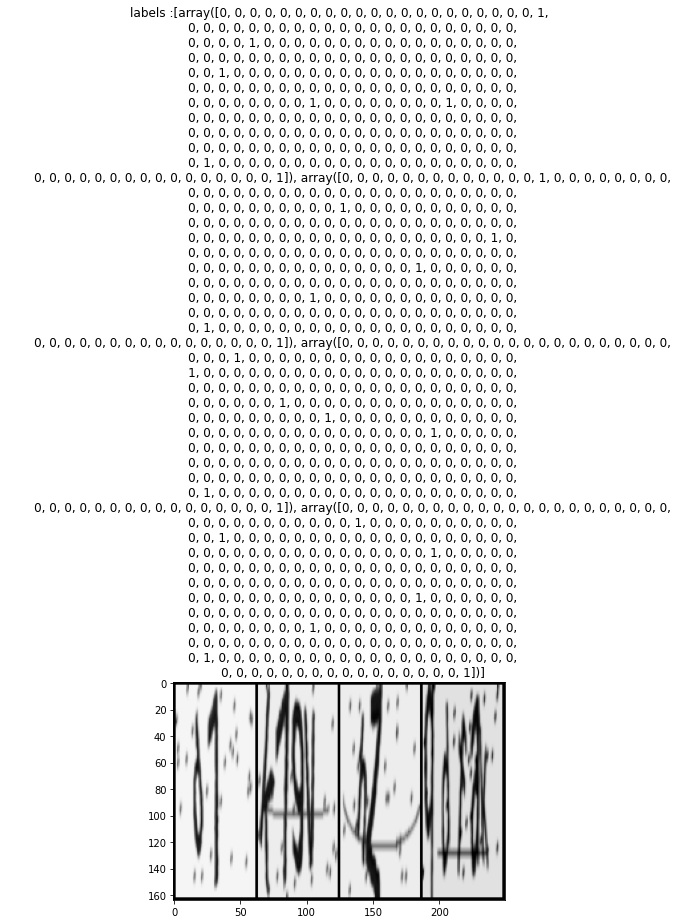

In [ ]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [ ]:
'''Problem2.2: Replace ResNet model to your own CNN model from AS2'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import resnet

Net = resnet.resnet18(pretrained=False)
Net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Net.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
Net = Net.to(device)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

In [ ]:
#LSTM 

    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
       
    def forward(self, x_3d):
        hidden = None
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  
            out, hidden = self.lstm(x.unsqueeze(0), hidden)         

        x = self.fc1(out[-1, :, :])
        x = F.relu(x)
        x = self.fc2(x)
        return x


class LSTM(nn.Module):
    def __init__(self, cnn_dim, hidden_size, vocab_size, num_layers=1):
        super(LSTM, self).__init__()
    
        self.cnn_dim = cnn_dim
        self.hidden_size = hidden_size   
        self.vocab_size = vocab_size
        
        # Building your LSTM cell
        self.lstm_cell = nn.LSTMCell(input_size=self.vocab_size, hidden_size=hidden_size)
    
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        '''Problem2.1 : Connect CNN model to LSTM model'''
        
        # output fully connected layer
        self.fc_in = nn.Linear(in_features,out_features)
        self.fc_out = nn.Linear(in_features,out_features)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)


    def forward(self, features, captions): 
        batch_size = features.size(0)
        cnn_dim = features.size(1)
        
        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()  # Initialize hidden state with zeros
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()   # Initialize cell state with zeros
        
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()   
        captions_embed = self.embed(captions)  
        
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        '''Problem1: Design LSTM model for captcha image recognition'''
        for t in range(captions).size(1):
            # for the first time step the input is the feature vector
            if t == 0:
                
            # for the 2nd+ time steps
            else:

            # build the output tensor

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    
        return outputs  # 정답으로 예측한 값

IndentationError: ignored

In [ ]:
cnn_dim=512   #resnet18-512
hidden_size=128   
vocab_size=37     #ALL_CHAR_SET_LEN

lstm = LSTM(cnn_dim=cnn_dim, hidden_size=hidden_size, vocab_size=vocab_size)
lstm = lstm.to(device)

In [ ]:
'''DEFINE loss, optimizer'''
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
loss_func = nn.MultiLabelSoftMarginLoss()
cnn_optim = torch.optim.Adam(Net.parameters(), lr=0.001)
lstm_optim = torch.optim.Adam(lstm.parameters(), lr=0.01)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

## TRAIN

In [ ]:
print_interval = 15
max_epoch = 30
use_lstm = False
tf_rate = 1

for epoch in range(max_epoch):
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.float()).cuda() 
        batch_size, _ = label_oh.shape
        pred, feature = Net(img) 
        
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        if use_lstm:
          outputs = lstm(feature, label_oh.view(1,MAX_CAPTCHA,ALL_CHAR_SET_LEN).argmax(dim=2))
          pred = outputs.view(1, -1) 


        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
            
        loss = loss_func(pred, label_oh) 
        
        
        cnn_optim.zero_grad()   
        loss.backward()         
        cnn_optim.step()        
        
        if (step+1)%print_interval == 0:
            print('epoch:', epoch+1, 'step:', step+1, 'loss:', loss.item())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1 step: 15 loss: 0.07431503385305405
epoch: 1 step: 30 loss: 0.0733657255768776
epoch: 1 step: 45 loss: 0.07244344800710678
epoch: 1 step: 60 loss: 0.0729769617319107
epoch: 1 step: 75 loss: 0.07108470797538757
epoch: 2 step: 15 loss: 0.07426358759403229
epoch: 2 step: 30 loss: 0.07330890744924545
epoch: 2 step: 45 loss: 0.07244512438774109
epoch: 2 step: 60 loss: 0.07288624346256256
epoch: 2 step: 75 loss: 0.07107740640640259
epoch: 3 step: 15 loss: 0.07406951487064362
epoch: 3 step: 30 loss: 0.07312744855880737
epoch: 3 step: 45 loss: 0.07242897152900696
epoch: 3 step: 60 loss: 0.07300060242414474
epoch: 3 step: 75 loss: 0.07111348956823349
epoch: 4 step: 15 loss: 0.07357645779848099
epoch: 4 step: 30 loss: 0.07275119423866272
epoch: 4 step: 45 loss: 0.07216455042362213
epoch: 4 step: 60 loss: 0.07302964478731155
epoch: 4 step: 75 loss: 0.07109459489583969
epoch: 5 step: 15 loss: 0.0734919086098671
epoch: 5 step: 30 loss: 0.07093502581119537
epoch: 5 step: 45 loss: 0.072336323

## TEST

In [ ]:
use_lstm = False
tf_rate = 0
char_correct = 0
word_correct = 0
total = 0

Net.eval()
#lstm.eval()

def get_str(ch_arr):
    ch_str = ''
    for ch in ch_arr:
        if ch == 'NONE':
            ch_str = ch_str + '_'
        else:
            ch_str = ch_str + ch
    return ch_str

with torch.no_grad(): 
    for step, (img, label_oh, label) in enumerate(test_dl):
        img = Variable(img).cuda()  
        label_oh = Variable(label_oh.float()).cuda()
        pred, feature = Net(img)
        
        if use_lstm:
            outputs = lstm(feature, label_oh.view(1,MAX_CAPTCHA,ALL_CHAR_SET_LEN).argmax(dim=2))
            pred = outputs.view(1, -1) 
        pred = pred.squeeze(0)
        label_oh = label_oh.squeeze(0)
        c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
        c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
        c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
        c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
        c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
        c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
        c6 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*6:ALL_CHAR_SET_LEN*7])]
    
        d0 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[0:ALL_CHAR_SET_LEN])]
        d1 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
        d2 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
        d3 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
        d4 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
        d5 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
        d6 = ALL_CHAR_SET[np.argmax(label_oh.cpu().tolist()[ALL_CHAR_SET_LEN*6:ALL_CHAR_SET_LEN*7])]
        
        c_arr = (c0, c1, c2, c3, c4, c5, c6)
        d_arr = (d0, d1, d2, d3, d4, d5, d6)
    
        c = '%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6)
        d = '%s%s%s%s%s%s%s' % (d0, d1, d2, d3, d4, d5, d6)
    
        c = get_str(c_arr)
        d = get_str(d_arr)

        char_correct += (c0==d0)+(c1==d1)+(c2==d2)+(c3==d3)+(c4==d4)+(c5==d5)+(c6==d6)
        word_correct += (c==d)
        total += 1
        
        print('label:', d, ', pred:', c)
        
print(100/7*char_correct/total)
print(100*word_correct/total)

"""END TEST"""

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


label: b9x____ , pred: ktvl___
label: mb_____ , pred: uimx___
label: d5q7qh_ , pred: ipm____
label: 6tl0kqv , pred: 7m_____
label: t1_____ , pred: io_____
label: avhjn3z , pred: c82____
label: 74z0z__ , pred: ibtb___
label: f1kfa__ , pred: i5i____
label: sripns_ , pred: mc8i___
label: bg4____ , pred: 8l4____
label: gmb45tz , pred: ba2____
label: sr5____ , pred: b7t8___
label: 0nt____ , pred: kpt____
label: lxfg98_ , pred: q9ot___
label: 2b8o___ , pred: pi74___
label: kr25___ , pred: xp_____
label: fl_____ , pred: xpfp___
label: 0tiwrd_ , pred: wp_6___
label: k5_____ , pred: ebt____
label: 8k_____ , pred: i8w6___
label: ggin___ , pred: dp2____
label: qc6e___ , pred: 8ssd___
label: giz6rv_ , pred: ab5n___
label: tf15___ , pred: cpst1__
label: 7jz____ , pred: qb2____
label: v3zl9__ , pred: 1t_6___
label: p78ec__ , pred: cptwr__
label: 7rh____ , pred: i50t___
label: exqo___ , pred: iimjo__
label: yrs____ , pred: 058xz__
label: si_____ , pred: um3j___
label: n4tikm_ , pred: u9_____
label: l

'END TEST'